# Funções

In [42]:
import time
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                           aneis (lista): tamanho do raio do círculo em km
                           lon_r (float): valor da longitude do centro do círculo em graus
                           lat_r (float): valor da latitude do centro do círculo em graus
                           color (str): cor do raio do círculo
                           label (str): legenda

    Parâmetros de saída:
                         latitude e longitude que delimita os círculos de distância centrado no radar e plota os círculos

    Exemplo:
             evm_plota_aneis_em_geral([100], -45.97279, -23.600795, 'gray', label='Radar: 100 km')
    """

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, ls='--', lw=1.5)

# Figura

CPU times: total: 29.4 s
Wall time: 30 s


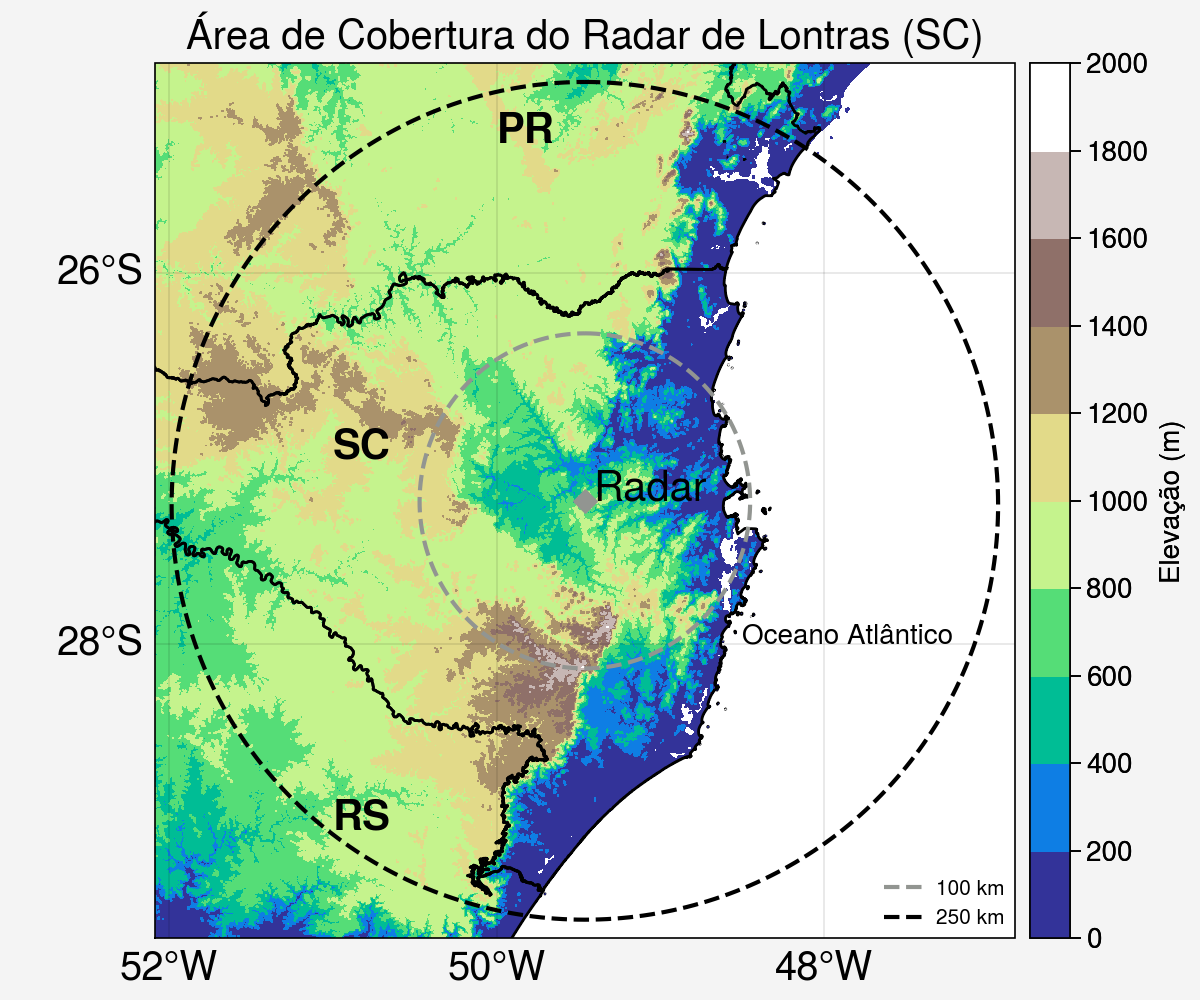

In [43]:
%%time
#========================================================================================================================#
#                                             IMPORTA BIBLIOTECAS
#========================================================================================================================#
import pyart                             # Biblioteca para trabalhar com dados de radar
import matplotlib.pyplot as plt          # Biblioteca para gerar gráficos
import cartopy.crs as ccrs               # Biblioteca para trabalhar com projeções de mapas
import numpy as np                       # Biblioteca para trabalhar com matrizes
import pandas as pd                      # Biblioteca para trabalhar com dataframes
import geopy                             # Biblioteca para geocodificação
from geopy import distance               # Função para calculo de distância
import salem                             # Biblioteca para leitura de shapefiles
from bmi_topography import Topography    # carrega a função que plota topografia
import proplot as pplt

# ignora avisos
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                             CAMINHO DOS DIRETÓRIOS
#========================================================================================================================#
dir_input = 'input/2023-02-19/'

#========================================================================================================================#
#                                             LEITURA DO DADO DE RADAR
#========================================================================================================================#
# leitura do arquivo
#filename = 'PNOVA2-20230219235502.HDF5'
#radar = pyart.aux_io.read_gamic(f'{dir_input}{filename}')

filename = 'R13227490_202405180003.hdf'
radar = pyart.aux_io.read_odim_h5(f'{dir_input}{filename}')

# extrai a latitude e longitude do radar
lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]

# limites dos dados
latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()

# definindo a extensão dos dados em termos de latitude/longitude
lonmin = lonmin-0.2
lonmax = lonmax+0.2
latmin = latmin-0.2
latmax = latmax+0.2

#========================================================================================================================#
#                                             LEITURA DO DADO DE RELEVO
#========================================================================================================================#
topo = Topography(dem_type="SRTMGL3",
                  south=latmin,
                  north=latmax,
                  west=lonmin,
                  east=lonmax,
                  output_format="GTiff",
                  cache_dir=".")

ds = topo.load()

#========================================================================================================================#
#                                                     PLOTA FIGURA
#========================================================================================================================#
#--------------------------#
#     plota relevo
#--------------------------#
# moldura da figura
fig, ax = pplt.subplots(figsize=(6., 5), tight=True, proj='pcarree')

# formatação dos eixos da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=2, lonlines=2,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title='Área de Cobertura do Radar de Lontras (SC)',
          small='20px', large='20px')

# plota mapa de relevo
map1 = ax.contourf(ds['x'],
                   ds['y'],
                   ds[0,:,:],
                   cmap='terrain',
                   vmin=0)

#--------------------------#
# plota radar/aneis/siglas
#--------------------------#
ax.scatter(lon_radar, lat_radar, transform=ccrs.PlateCarree(), marker='D', s=35, color='gray')
plt.text(lon_radar+0.05, lat_radar,'Radar', size=15)

# plota o shapefile dos Estados
estados_brasil = salem.read_shapefile('utils/BR_UF_2019.shp')
estados_selecionado = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SC') | (estados_brasil['SIGLA_UF'] == 'PR') | (estados_brasil['SIGLA_UF'] == 'RS')]
estados_selecionado.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=1, ax=ax)

# plota siglas dos estados
ax.annotate('PR', xy=(-50, -25.3), fontsize=15, color='black', weight='bold')
ax.annotate('SC', xy=(-51, -27.0), fontsize=15, color='black', weight='bold')
ax.annotate('RS', xy=(-51, -29), fontsize=15, color='black', weight='bold')
ax.annotate('Oceano Atlântico', xy=(-48.5, -28.0), fontsize=10, color='black')

# plota os aneis de distância do radar
evm_plota_aneis_em_geral([100], lon_radar, lat_radar, 'gray', label='100 km')
evm_plota_aneis_em_geral([250], lon_radar, lat_radar, 'black', label='250 km')

#--------------------------#
# plota barra de cor/legenda
#--------------------------#
# plota barra de cores da figura
fig.colorbar(map1, loc='right', label='Elevação (m)', ticklabelsize=10, labelsize=10, space=-5.6)

# adiciona legenda
ax.legend(loc='lr', ncols=1, frameon=False, prop={'size':7.5}, markerscale=0.4)

#--------------------------#
#      salva figura
#--------------------------#
fig.save(f'output/01_cobertura_radar/radar_Lontras_SC.png', dpi=300)